In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
# import matplotlib
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from six.moves.urllib.request import urlretrieve

from matplotlib.pyplot import imshow

In [2]:
np.random.seed(3)

num_classes = 2
folders = ['images/faces', 'images/not']

images/not/val_983.JPEG


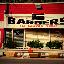

In [3]:
im_path = folders[1] + "/" + os.listdir(folders[1])[0]
print(im_path)
Image(im_path)

In [4]:
# %matplotlib inline

image_size = 64  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_dim = 1

def load_label(folder, min_num_images):
    
    #get all images
    image_files = os.listdir(folder)
    
    first = True
    
    image_index = 0
    
    for image in os.listdir(folder)[:1000]:
        image_file = os.path.join(folder, image)

        try:
            images = []
            
            # load image
            image_data = ndimage.imread(image_file).astype(float)
#             print(len(image_data.shape))
            
            if len(image_data.shape) > 2:
                image_data = image_data[:,:,0]
            
            # resize to target resolution if necessary
            if image_data.shape[0] != image_size:
                image_data2 = misc.imresize(image_data2, (image_size, image_size), interp='nearest')
            
            # normalize
            image_data = (image_data - image_data.mean()) / image_data.std() / 2
            
            # add contrast
            
            images.append(image_data)
            
            # create new data through transformations
#             images.append(np.flipud(image_data))
#             images.append(np.fliplr(image_data))
#             images.append(np.rot90(image_data, 1))
#             images.append(np.rot90(image_data, 2))
#             images.append(np.rot90(image_data, 3))

            for img in images:
                image_data_format = np.ndarray((1,image_size, image_size, image_dim), dtype=np.float32)
                image_data_format[0,:,:,0] = img[:,:]
            
                if first:
                    dataset = image_data_format
                    first = False
                else:
                    dataset = np.concatenate((dataset,image_data_format), axis=0)
            
            image_index += 1
            
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
            

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_label(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

datasets = maybe_pickle(folders, 50, True)

Pickling images/faces.pickle.
Full dataset tensor: (1000, 64, 64, 1)
Mean: 3.42261e-11
Standard deviation: 0.5
Pickling images/not.pickle.
Full dataset tensor: (1000, 64, 64, 1)
Mean: -1.67987e-10
Standard deviation: 0.5


(64, 64)
[[-0.46417019 -0.46417019 -0.46417019 ..., -0.31616762 -0.31616762
  -0.31616762]
 [-0.46417019 -0.46417019 -0.46417019 ..., -0.31616762 -0.31616762
  -0.31616762]
 [-0.46417019 -0.46417019 -0.46417019 ..., -0.34576812 -0.34576812
  -0.34576812]
 ..., 
 [ 0.15744063  0.15744063  0.15744063 ...,  0.45344579  0.45344579
   0.45344579]
 [ 0.15744063  0.15744063  0.15744063 ...,  0.45344579  0.45344579
   0.45344579]
 [ 0.15744063  0.15744063  0.15744063 ...,  0.45344579  0.45344579
   0.45344579]]


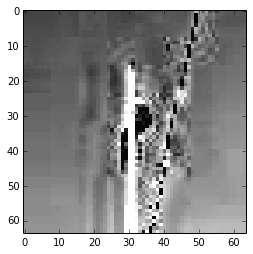

In [5]:
%matplotlib inline

def showImage(pickle_files, setNum, imgNum):
    with open(pickle_files[setNum], 'rb') as f:
        cat_set = pickle.load(f)
#         print (len(cat_set))
    return cat_set[imgNum]


img = showImage(datasets, 1, 1)[:,:,0]

print(img.shape)
print (img)
imshow(img, cmap = plt.get_cmap('gray'), vmin = -1, vmax = 1,  interpolation='nearest')

In [6]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size, image_dim), dtype=np.float32)
#     dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size, test_size):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    test_dataset, test_labels = make_arrays(test_size, image_size)
    val_size_per_class = valid_size // num_classes
    train_size_per_class = train_size // num_classes
    test_size_per_class = test_size // num_classes
    
    start_val, start_train, start_test = 0, 0, 0
    end_val, end_train, end_test = val_size_per_class, train_size_per_class, test_size_per_class
    #   end_l = val_size_per_class + train_size_per_class + test_size_per_class

    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                cat_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(cat_set)

                valid_cat = cat_set[:val_size_per_class, :, :, :]
                valid_dataset[start_val:end_val, :, :, :] = valid_cat
                valid_labels[start_val:end_val] = label
                start_val += val_size_per_class
                end_val += val_size_per_class

                train_cat = cat_set[val_size_per_class:val_size_per_class + train_size_per_class, :, :, :]
                train_dataset[start_train:end_train, :, :, :] = train_cat
                train_labels[start_train:end_train] = label
                start_train += train_size_per_class
                end_train += train_size_per_class

                test_cat = cat_set[val_size_per_class + train_size_per_class:val_size_per_class + train_size_per_class + test_size_per_class, :, :, :]
                test_dataset[start_test:end_test, :, :, :] = test_cat
                test_labels[start_test:end_test] = label
                start_test += test_size_per_class
                end_test += test_size_per_class

        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels
            
            
train_size = 800
valid_size = 200
test_size = 200

valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels = merge_datasets(
  datasets, train_size, valid_size, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (800, 64, 64, 1) (800,)
Validation: (200, 64, 64, 1) (200,)
Testing: (200, 64, 64, 1) (200,)


In [7]:
print (train_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [8]:
def randomize(dataset, labels):
    
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [9]:
pickle_file = 'images.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [10]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 19666042
